## Logistic Regression - Titanic

The titanic dataset is a popular dummy dataset used to learn about logistic regression. It has also been used in a [Kaggle data science competition](https://www.kaggle.com/c/titanic), so you'll also find blogposts exploring all kinds of more advanced concepts that use this dataset too! In this assignment, you'll do a logistic regression to look at the effect of sex and class on survival on the titanic, by computing odds ratios.

adapted from: https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-homework.ipynb

Some references:

- [What are odds vs. probability?](https://towcenter.gitbooks.io/curious-journalist-s-guide-to-data/content/analysis/counting_possible_worlds.html)
- [Investigate.ai on Logistic Regressions](https://investigate.ai/regression/logistic-regression-quickstart/)
- [StatQuest Logistic Regressions Playlist](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)
- [How do I interpret odds ratios in logistic regression?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) This one's a little more technical, but has good examples.


In [1]:
import pandas as pd
import numpy as np 
from plotnine import *

/Users/stephenanti/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Load the data

Read in the `titanic.csv` data set again.

In [2]:
# Load titanic.csv
df = pd.read_csv('titanic.csv')
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender
0,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male
3,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male
...,...,...,...,...,...,...,...,...,...,...
1308,3rd,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male
1309,3rd,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male
1310,3rd,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male
1311,3rd,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female


The first thing we need to do is code the pclass and gender variables numerically. Let's use the following scheme:
- pclass: 1,2,3
- gender: 0=male, 1=female, and let's call the column called "female" to remind us which is which

In [3]:
# recode the pclass and gender variables so they are numeric
df['pclass'] = df.pclass.replace({'1st': 1, '2nd': 2, '3rd': 3})
df['female'] = df.gender.replace({'male': 0, 'female': 1})
df.head(3)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0


### 1. Exploratory data analysis

In [4]:
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0


In [5]:
# First, let's do some descriptive stats
# How many men and women are travelling on the titanic?
# How many people are travelling in each class?
# What share of each survived?
piv = df.pivot_table(index='survived', columns='female', aggfunc='count', values='name')
display(piv)

pct_survived = piv.apply(lambda x: x/sum(x)).round(2)
display(pct_survived)

female,0,1
survived,,
0,708,156
1,142,307


female,0,1
survived,,
0,0.83,0.34
1,0.17,0.66


### 2. Logistic regression with one variable at a time

First, do a logistic regression of the `female` variable alone to predict the probability of survival. Below is some code that will help you plot the result.

In [6]:
# Step 1: Run a logistic regression on one variable and see the summary of the output
# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

import statsmodels.formula.api as smf

model = smf.logit("survived ~ female", data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.517411
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.1945
Time:                        15:02:02   Log-Likelihood:                -679.36
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.572e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6066      0.092    -17.473      0.000      -1.787      -1.426
female         2.2836      0.135     16.963      0.000       2.020       2.547
==============================================================================
"""

In [7]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['prediction'] = results.predict()
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.663067


In [8]:
df.prediction.unique()

array([0.66306695, 0.16705882])

In [9]:
# Step 3: What is the odds ratio of on the gender variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

,coef,odds ratio,pvalue,name
Intercept,-1.606617,0.200565,2.306853e-68,Intercept
female,2.283609,9.812026,1.529597e-64,female


Now, try the same thing but with the `pclass` variable

In [10]:
# Step 1: Run a logistic regression on one variable and see the summary of the output

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

model = smf.logit("survived ~ pclass", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.576759
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.1021
Time:                        15:02:04   Log-Likelihood:                -757.28
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.459e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3996      0.170      8.236      0.000       1.067       1.733
pclass        -0.9285      0.074    -12.611      0.000      -1.073      -0.784
==============================================================================
"""

In [11]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['class_predict']= results.predict()
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction,class_predict
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067,0.615642
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067,0.615642
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059,0.615642
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067,0.615642
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059,0.615642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059,0.200052
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059,0.200052
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059,0.200052
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.663067,0.200052


In [12]:
# Step 3: What is the odds ratio of on the pclass variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs


,coef,odds ratio,pvalue,name
Intercept,1.399625,4.053680,1.778696e-16,Intercept
pclass,-0.928532,0.395133,1.832570e-36,pclass


**Bonus** 🤖 - Writing clean/DRY code

DRY stands for "Don't Repeat Yourself". This is a good principle of writing clean code. Instead of copy/pasting code multiple times (which can lead to errors if you fix one copy but not the other), you can write DRY code by wrapping any chunk of code you plan to repeat in a function. As a bonus on this section, re-write the code above as a function and run that function once on `female` and once on `pclass`.

### 3. Looking at two variables at a time

We know from the earlier assignment that class also affects survival, so let's add that to our model. Compute a logistic regression on the variables `pclass` and `female`.

In [13]:
# Logistic regression on two variables

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

In [14]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

In [15]:
# Step 3: What is the odds ratio of on the gender variable?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

In [16]:
# COefficient is the log of the odds ratio in a logistics regression

### 4. What does this mean

What is the odds ratio on the `pclass` variable? What happens to the odds of survival when we move from 1st to 2nd or from 2nd to 3rd class?


👉

### 5. Bonus - Age

Does the age of a passenger impact their chances of survival?

In [19]:
model = smf.logit("survived ~ age", data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.683624
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      631
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                0.004687
Time:                        15:03:14   Log-Likelihood:                -432.73
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                   0.04351
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1172      0.188      0.624      0.532      -0.251       0.485
age           -0.0110      0.005     -2.008      0.045      -0.022      -0.000
==============================================================================
"""

In [20]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

,coef,odds ratio,pvalue,name
Intercept,0.117195,1.124339,0.532483,Intercept
age,-0.011029,0.989031,0.044647,age


<AxesSubplot:>

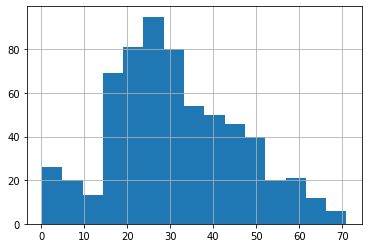

In [22]:
df.age.hist(bins=15)

In [24]:
from plotnine import*

In [33]:
age= df.age.dropna()
age

0      29.0000
1       2.0000
2      30.0000
3      25.0000
4       0.9167
        ...   
833    32.0000
835    20.0000
836    37.0000
837    28.0000
838    19.0000
Name: age, Length: 633, dtype: float64

In [34]:
age= df.query('age.notnull()')
age

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction,class_predict
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067,0.615642
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067,0.615642
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059,0.615642
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067,0.615642
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059,0.615642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,3,0,"Gronnestad, Mr Daniel Danielsen",32.0000,Southampton,"Foresvik, Norway Portland, ND",NaN,NaN,NaN,male,0,0.167059,0.200052
835,3,0,"Gustafsson, Mr Alfred Ossian",20.0000,Southampton,"Waukegan, Chicago, IL",NaN,NaN,NaN,male,0,0.167059,0.200052
836,3,0,"Gustafsson, Mr Anders Vilhelm",37.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",NaN,NaN,NaN,male,0,0.167059,0.200052
837,3,0,"Gustafsson, Mr Johan Birger",28.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",NaN,NaN,NaN,male,0,0.167059,0.200052


/Users/stephenanti/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.


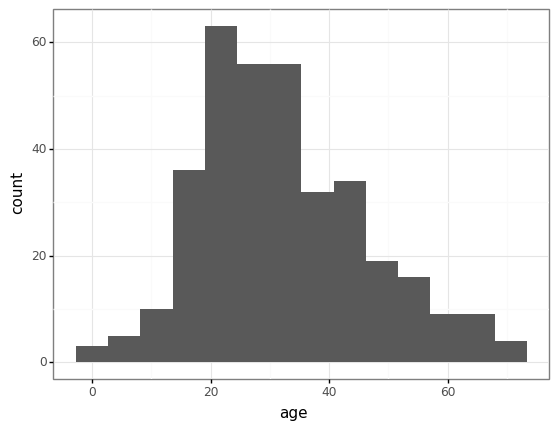

<ggplot: (395285803)>

In [35]:
# those who did not survive
(
ggplot(age.query('survived == 0'))
    +aes('age')
    +geom_histogram()
    +theme_bw()
)

/Users/stephenanti/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


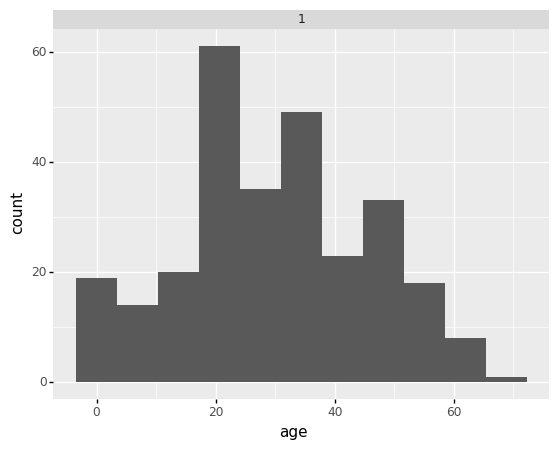

<ggplot: (395467108)>

In [40]:
# those who survived
(
ggplot(age.query('survived==1'))
    +aes('age')
    +geom_histogram()
    +facet_wrap('survived')
 
)

/Users/stephenanti/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 16'. Pick better value with 'binwidth'.


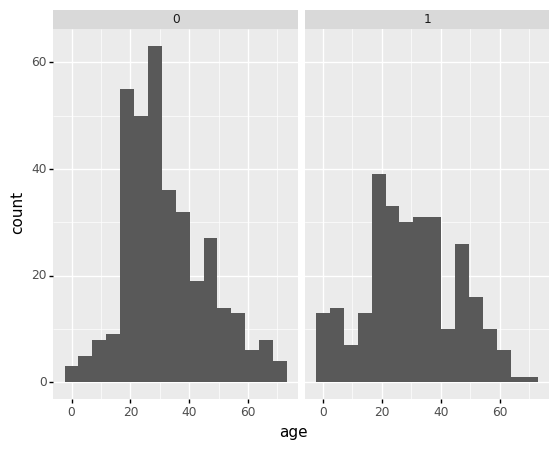

<ggplot: (395504207)>

In [41]:
(
ggplot(age)
    +aes('age')
    +geom_histogram()
    +facet_wrap('survived')
 
)